# Sentiment Analysis on Movie Reviews



---
## Descrição do problema:
---
<b>Sentiment Analysis on Movie Reviews</b><p>
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews


<b>Description</b>

The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee [1]. In their work on sentiment treebanks, Socher et al. [2] used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

<b>Evaluation</b>
 
Submissions are evaluated on classification accuracy (the percent of labels that are predicted correctly) for every parsed phrase. The sentiment labels are:
0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive
 
<b>Data</b><p>
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

<p>Output Format</p>
For each phrase in the test set, predict a label for the sentiment.Share your solution(code) in Github and share your score with us. Your output format should have a header and look like the following:<p><p>
*PhraseId,Sentiment<br>156061,2<br>156062,2<br>156063,2*

# Resumo da análise

Neste notebook, serão utilizadas algumas técnicas comuns na literatura de Natural Language Processing (NLP) para manipulação,processamento e representação de texto em uma abstração de dados que possa ser fornecida para algoritmos de mineração de dados e realizar a análise de sentimento conforme proposto na descrição da competição do Kaggle. 




>### Por que o Texto é difícil
> O texto costuma ser chamado de dados "não estruturados". Isso se refere ao fato de que o texto não tem o tipo de estrutura que normalmente esperamos dos dados: tabelas de registros com campos com significados fixos (essencialmente, coleções de vetores de características), bem como ligações entre as tabelas. O texto, é claro, possui muitas estruturas, mas é uma estrutura *linguística* - destinada ao consumo humano, não para computadores. <p><p> - (*Pág 252, Data Science para Negócios: O que você precisa saber sobre mineração de dados e pensamento analítico de dados ,2016*)


**Algumas terminologias que serão usadas ao longo desta análise:**<p>
+ *Document*: Um pedaço de texto, não importando o seu tamanho. Pode ser uma frase, um livro inteiro ou qualquer coisa entre eles
+ *Token*: Unidades ou termos que constituem um *Document*. Numa aproximação grosseira, é cada uma das palavras que compõem um *Document*.
+ *Corpus*: Um conjunto ou coleção de *Documents*


In [1]:
import time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#Desligando os avisos para deixar a leitura menos poluída
warnings.filterwarnings('ignore')

## 1. Explorando os dados

In [2]:
train = pd.read_table('train.tsv.zip', compression='zip')
test = pd.read_table('test.tsv.zip', compression='zip')

In [3]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [5]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [6]:
test.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
dtype: int64

In [7]:
train.shape

(156060, 4)

In [8]:
test.shape

(66292, 3)

### Resumo rápido dos dados:
+ O conjunto de *treinamento* tem 156.060 registros e 4 colunas (A última coluna contém os labels das classes a serem previstas)
+ O conjunto de *teste* tem 66.292 registros e 3 colunas
+ Os conjuntos não tem dados nulos


In [9]:
class_labels = {0:'negative',1:'somewhat negative',2:'neutral',3:'somewhat positive', 4:'positive'}

document_train = train[['Phrase','Sentiment']]
document_train_grouped = document_train.groupby('Sentiment').count().reset_index()
document_train_grouped.columns = ['Sentiment','Qtd']
document_train_grouped['Qtd'] = document_train_grouped['Qtd']/document_train_grouped['Qtd'].sum() * 100
document_train_grouped.Sentiment = document_train_grouped.Sentiment.map(class_labels)

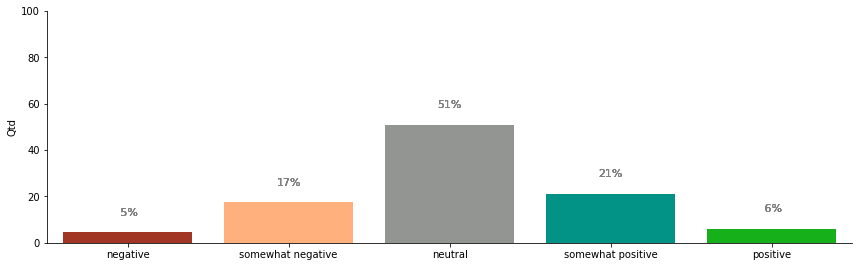

In [10]:
cores = ['brick','peach','grey','teal','green']
paleta = sns.xkcd_palette(cores)

g = sns.factorplot(x='Sentiment',y='Qtd',data=document_train_grouped,kind='bar',size=4,aspect=3,
                   saturation=5, legend=False,palette=paleta)

g.set(ylim=(0,100))
g.despine()
g.set_xlabels('')



ax = g.ax

#função para colocar rótulos nas barras do gráfico
def annotateBars(row, ax=ax):
    for p in ax.patches:
        ax.annotate('%2.f%%' % p.get_height(),       #formato de porcentagem do rótulo na altura da barra xi do gráfico
                    (p.get_x() + p.get_width()/2,    #posição do rótulo da barra xi no eixo x
                     p.get_height()),                 #posição do rótula da barra xi no eixo y
                     ha='center',                    #alinhamento horizontal do rótulo  
                     va='center',                    #alinhamento vertical do rótulo  
                     fontsize=11,                    #tamanho da fonte do rótulo
                     color='grey',                   #cor da fonte do rótulo
                     xytext=(0,20),                  #coordenadas xy do texto do rótulo
                     textcoords='offset points'      #tipo de coordenadas xy do texto (points ou pixels)
                   ) 

grafico = document_train_grouped.apply(annotateBars,ax=ax, axis=1)


*Participação em percentual dos reviews no conjunto de treinamento. *<br><br><br><br><br><br>

** Stop Words**

>(...) Uma _stop word_ é uma palavra muito comum no idioma que está sendo analisado. As palavras _a, the, from, to_ são consideradas _stop words_, por isso, costumam ser removidas --- *Data Science para Negócios, pág. 255*

In [11]:
# Gerar wordclouds para analisar os termos por Sentimento

# Código adaptado de https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis

from wordcloud import WordCloud, STOPWORDS
import re

negative = document_train[document_train['Sentiment'] == 0]
negative = negative['Phrase']

some_negative = document_train[document_train['Sentiment'] == 1]
some_negative = some_negative['Phrase']

neutral = document_train[document_train['Sentiment'] == 2]
neutral = neutral['Phrase']

some_positive = document_train[document_train['Sentiment'] == 3]
some_positive = some_positive['Phrase']

positive = document_train[document_train['Sentiment'] == 4]
positive = positive['Phrase']

lista = [negative,some_negative, neutral, some_positive, positive]

def gerarWordcloud(lista, cor):
    words = ' '.join(lista)
    words = re.sub('[^a-zA-Z0-9]', ' ', words)
    cleaned_word = ' '.join([word for word in words.split()])
    wc = WordCloud(stopwords=STOPWORDS,background_color=cor,width=2500,height=2500).generate(cleaned_word)
    plt.figure(figsize=(12,12))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()   

## Wordcloud dos reviews negativos - Class Label 0

*200 palavras mais comuns das sentenças classificadas com o label **0 (negative)** que compôem **6%** dos dados do conjunto de treinamento*

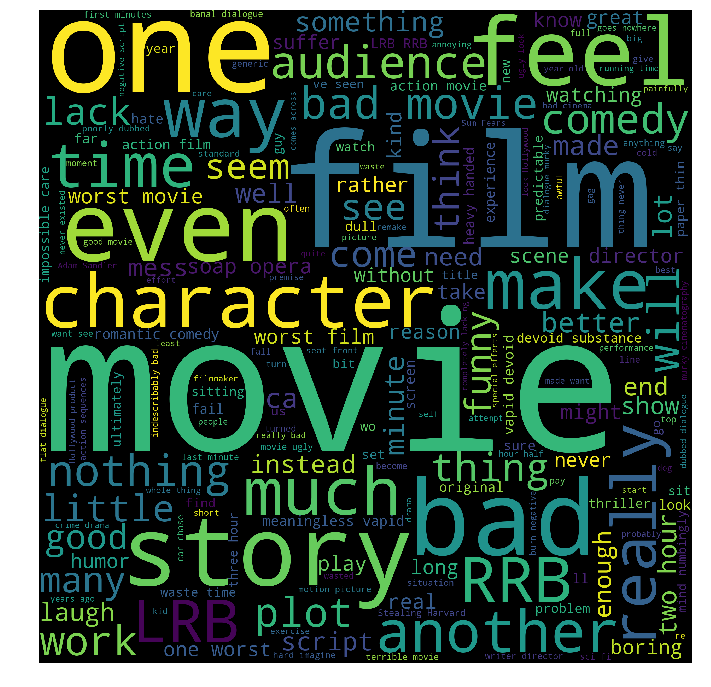

In [12]:
gerarWordcloud(negative,'black')

## Wordcloud dos reviews meio negativos - Class Label 1
*200 termos mais comuns das sentenças classificadas com o label **1 (somehwat negative)** que compõem **17%** dos dados do conjunto de treinamento*

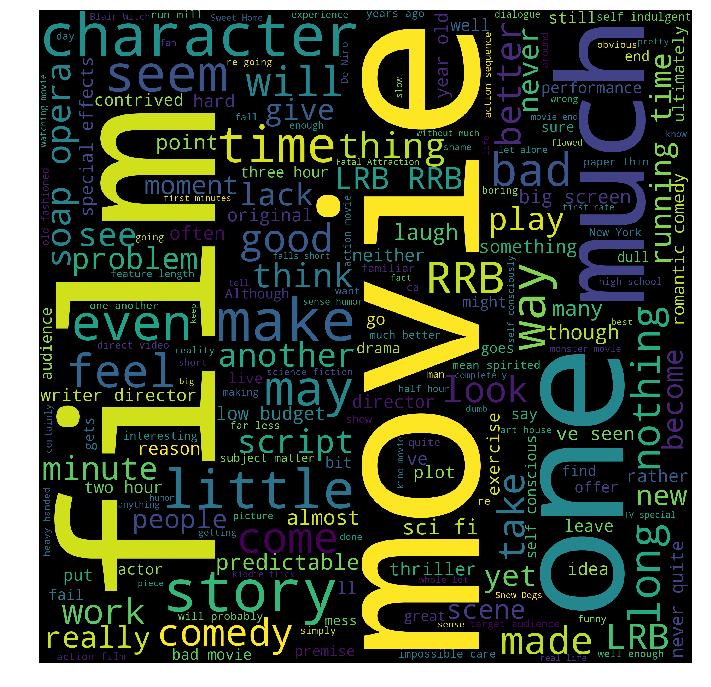

In [13]:
gerarWordcloud(some_negative,'black')

## Wordcloud dos reviews neutros - Class Label 2
*200 termos mais comuns das sentenças classificadas com o label **2 (neutral)** que compôem **51%** dos dados do conjunto de treinamento*

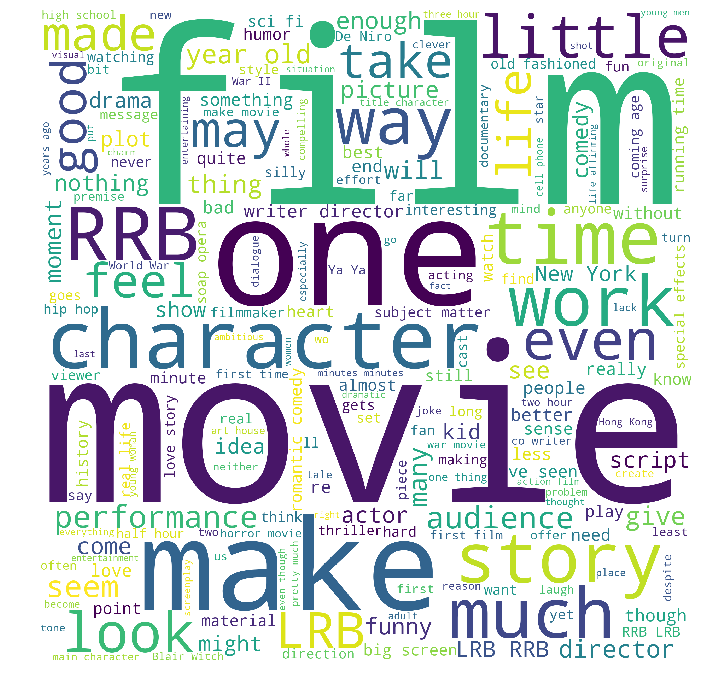

In [14]:
gerarWordcloud(neutral,'white')

## Wordcloud dos reviews meio positivos - Class Label 3
*200 termos mais comuns das sentenças classificadas como **3 (somewhat positive)** que compôem **21%** dos dados do conjunto de treinamento*

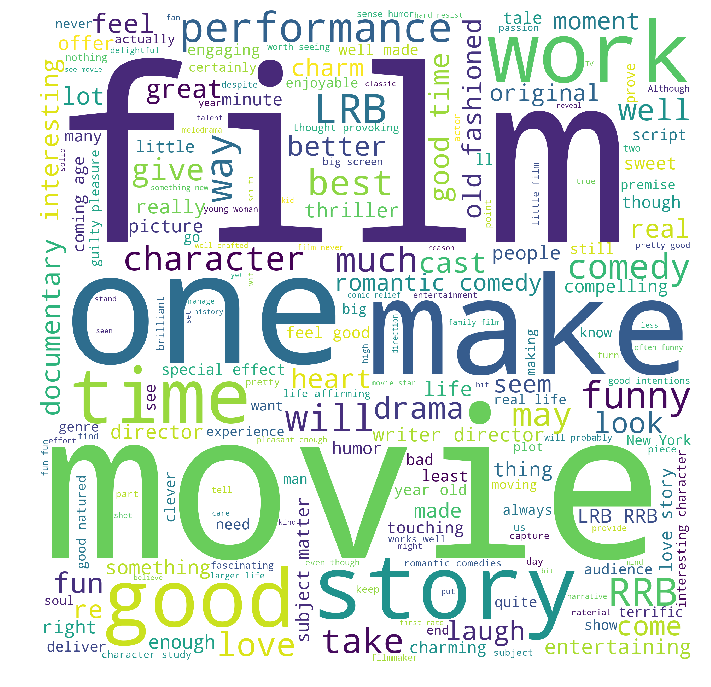

In [15]:
gerarWordcloud(some_positive,'white')

## Wordcloud dos reviews positivos - Class Label 4
*200 termos mais comuns das sentenças classificadas como **4 (positive)**, classe que constitue 6% dos dados do conjunto de treinamento*

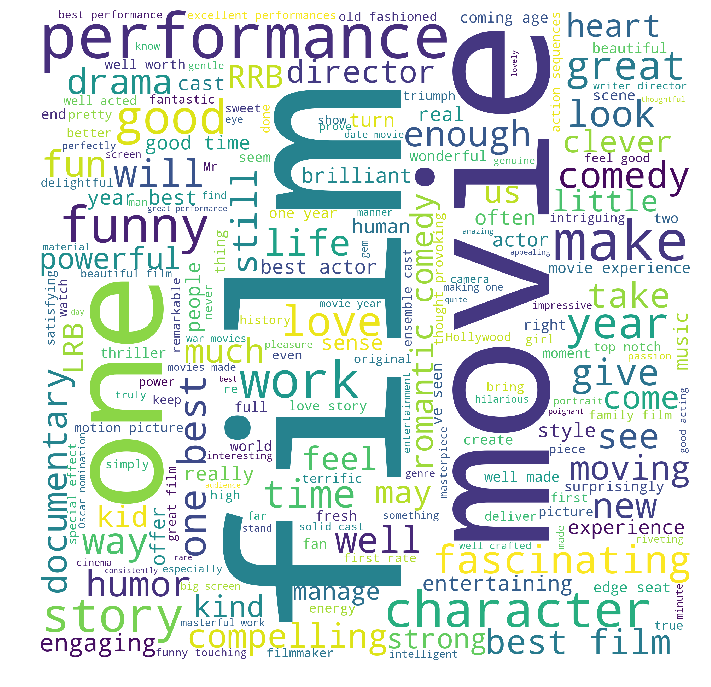

In [16]:
gerarWordcloud(positive,'white')

### Ao observar as wordclouds geradas para cada classificação de sentimento, conseguimos perceber alguns insights interessantes:


+ Para a categoria **'negative'**, chamam a atenção as palavras: **bad, plot, director,character,lack,comedy, boring, worst** que sugerem insatisfação com o enredo, caracterização dos personagens, direção, etc.<p>

+ Para a categoria **'somewhat negative'**, chamam a atenção as palavras: **long, little, time, minute, much** que sugerem uma percepção negativa com a duração dos filmes ou situações dos roteiros<p>

+ Para a categoria **'neutral'**, chamam a atenção as palavras: **sense, work, probably, seem, may**, que sugerem que os filmes nessa classificação não são ruins mais que poderiam ser melhores. Esta categoria já mostra que é necessário um tratamento mais aprofundado com o conjunto de dados para extração de conteúdos mais informativos<p>

+ Para a categoria **'somewhat positive'**, chamam a atenção as palavras: **old fashioned, charm, cast, genre,entertaining **, que sugerem que os filmes nessa classificação tiveram uma combinação muita boa de gênero, elenco e ritmo. Filmes que de alguma forma surpreenderam pela maneira como foram conduzidos.<p>

+ Para a categoria **'positive'** chamam a atenção as palavras: **fascinating, powerful, moving, year, compelling, experience**, que sugerem incríveis experiências de entretinemento cinematográfico como os blockbusters de super heróis, ganhadores de Oscar como filmes de arte e de diretores renomados.<p>

---

### Para esta primeira análise do conjunto de dados, já valem as seguintes ressalvas:

+ As categorias **'negative'** e **'positive'** são mais fáceis de se analisar porque estão nos extremos da escala, logo vão ter uma prevalência de termos negativos e positivos respectivamente, o que torna fácil identificá-las numa análise gráfica<p>

+ As categorias **'somewhat negative'** e **'somewhat positive'** são bastante interessantes pois contém termos menos previsíveis e podem revelar características pouco exploradas e de alto valor agregado<p>

+ A categoria **'neutral'** é a mais difícil de analisar pois os termos são bastante gerais e ambíguos, o que inviabiliza uma inferência rápida das características desse grupo que é metade do conjunto de dados.

+ Vários termos são bastante frequentes e comuns nas 5 categorias (tais como **one, movie, character,film**) o que é esperado, já que o tema do conjunto de dados é um só

## Resumindo:

São necessários métodos mais robustos de processamento dos dados para uma análise mais aprofundada do texto, tanto para descoberta de conhecimento como para construir os modelos preditivos. Para isto, os seguintes métodos serão utilizados a seguir:


**Bag of Words**

>(...)"Bag of words", em português "saco de palavras". Como o nome indica, a abordagem é tratar cada documento como uma coleção de palavras individuais. Essa abordagem ignora a gramática, a ordem das palavras, a estrutura da frase e (geralmente) a pontuação. Ela trata cada palavra em um documento como uma palavra-chave potencialmente importante. A representação é simples e barata de gerar e tende a funcionar bem para muitas tarefas --- *Data Science para Negócios, pág. 254*



**Stemização\Lematização**

>**Stemização**: Em morfologia linguística e recuperação de informação a stemização (do inglês, stemming) é o processo de reduzir palavras flexionadas (ou às vezes derivadas) ao seu tronco (stem), base ou raiz, geralmente uma forma da palavra escrita. O tronco não precisa ser idêntico à raiz morfológica da palavra; ele geralmente é suficiente que palavras relacionadas sejam mapeadas para o mesmo tronco, mesmo se este tronco não for ele próprio uma raiz válida. O estudo de algoritmos para stemização tem sido realizado em ciência da computação desde a década de 60. Vários motores de buscas tratam palavras com o mesmo tronco como sinônimos como um tipo de expansão de consulta, em um processo de combinação. É comum se referir aos programas de stemização como stemmers ou algoritmos de stemming. --- *Wikipedia, https://pt.wikipedia.org/wiki/Stemiza%C3%A7%C3%A3o, acessado em 01/05/2018*

>**Lematização**: Processo linguístico que consiste em reduzir uma palavra flexionada a sua parte essencial. --- *Dicionário Michaelis Online, http://michaelis.uol.com.br/busca?id=5Bbdk, acessado em 01/05/2018*

**TFIDF**

>Uma representação muito popular para o texto é o produto da Frequência do Termo (TF, do inglês *Term Frequency*) e da Frequência do Documento Inversa (IDF, do inglês *Inverse Document Frequency*), comumente chamado de TFIDF. O valor TFIDF de um termo *t* em determinado documento *d* é:<p>
&nbsp;&nbsp;&nbsp;&nbsp;TFIDF(*t*, *d*) x IDF(*t*)<p>

--- *Data Science para Negócios, pág 258*


**Sequências N-gramas**

>(...)A representação do bag of words trata cada palavra individual como um termo, descartando inteiramente sua ordem. Em alguns casos, a ordem das palavras é importante e você quer preservar algumas informações sobre ela na representação. Uma próxima etapa em complexidade é incluir *sequências* de palavras adjacentes como termos. Por exemplo, poderíamos incluir para de palavras adjacentes, de modo que, se um documento contém a frase "* A ligeira raposa marrom salta.*", será transformado no conjunto das palavras que a constituem {ligeira, marrom, raposa, salta}, além dos símbolos **``ligeira_raposa``**, **``raposa_marrom``** e **``marrom_salta``**. --- *Data Science para Negócios, pág 265*


# 2. Pré Processamento e Modelagem Preditiva

Após a etapa de visualização dos dados, serão testados alguns algoritmos de machine learning nos dados


In [17]:
#Importação das funções de vetorização de matrizes esparsas e da função que divide o conjunto de treinamento em treino e teste

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

X = document_train['Phrase']
y = document_train['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)

In [18]:
#Construindo um vocabulário de frequências 
vectorizer = TfidfVectorizer(sublinear_tf=True)

X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [19]:
print('Dimensões da matriz de termos-documentso do conjunto de treino: ',X_train_dtm.shape)
print('Dimensões da matriz de termos-documentso do conjunto de teste: ',X_test_dtm.shape)

Dimensões da matriz de termos-documentso do conjunto de treino:  (109242, 15212)
Dimensões da matriz de termos-documentso do conjunto de teste:  (46818, 15212)


### 1. Multinomial Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
%time clf.fit(X_train_dtm, y_train)


Wall time: 48 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [32]:
y_prediction_class = clf.predict(X_test_dtm)
resultado = metrics.accuracy_score(y_pred=y_prediction_class, y_true=y_test) * 100
score = clf.score(X_train_dtm, y_train) * 100
print('Acurácia do algoritmo: %.2f%%' % resultado)
print('Score do algoritmo: %.2f%%' % score)


Acurácia do algoritmo: 58.33%
Score do algoritmo: 63.22%


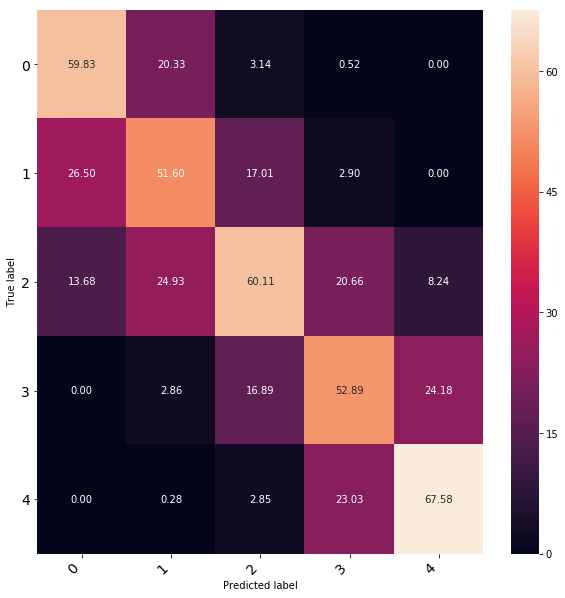

In [34]:
matriz_de_confusao = pd.DataFrame(metrics.confusion_matrix(y_true=y_test, y_pred=y_prediction_class)
                                 ,index=clf.classes_
                                 ,columns=clf.classes_)
plt.figure(figsize=(10,10))
plt.ylabel('Actual')
plt.xlabel('Predic')
heatmap = sns.heatmap(matriz_de_confusao.apply(lambda x: x/x.sum()*100), annot=True, fmt='.2f')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')


Utilizando o Multinomial Naive Bayes a performance foi de **58.33%** de acerto e **63.22%** de score. Observando a matriz de confusão (em valor percentual, para que o desbalanceamento das classes não atrapalhe a leitura do resultado), podemos ver que:

+ A classe 4 (Positive) obteve a melhor performance contra o conjunto de teste
+ A classe 2 (Neutral), por sua prevalência, acaba enviesando a classificação do algoritmo
+ O algoritmo é menos rigoroso na separação das classes que gera falsos positivos em torno de 25% das vezes para as classes imediatamente adjacentes
+ O conjunto de dados pode precisar de uma nova etapa de pré processamento


### 2. Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1.0, penalty='l1')
%time clf.fit(X_train_dtm, y_train)

Wall time: 2.12 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
y_prediction_class = clf.predict(X_test_dtm)
resultado = metrics.accuracy_score(y_pred=y_prediction_class, y_true=y_test) * 100
score = clf.score(X_train_dtm, y_train) * 100
print('Acurácia do algoritmo: %.2f%%' % resultado)
print('Score do algoritmo: %.2f%%' % score)


Acurácia do algoritmo: 62.58%
Score do algoritmo: 67.30%


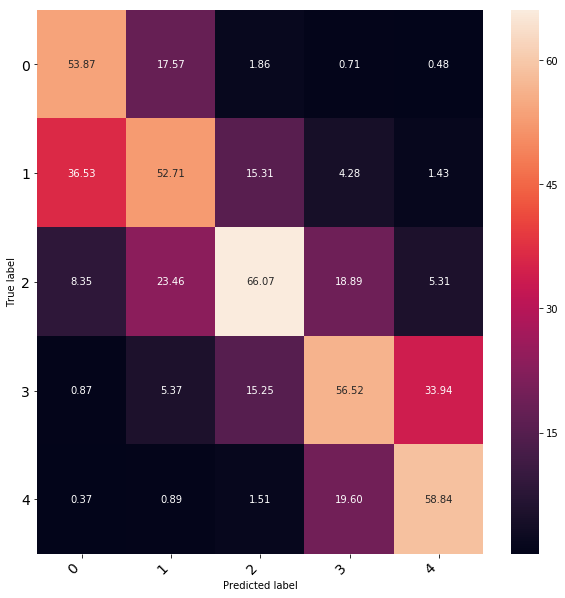

In [54]:
matriz_de_confusao = pd.DataFrame(metrics.confusion_matrix(y_true=y_test, y_pred=y_prediction_class)
                                 ,index=clf.classes_
                                 ,columns=clf.classes_)
plt.figure(figsize=(10,10))
plt.ylabel('Actual')
plt.xlabel('Predic')
heatmap = sns.heatmap(matriz_de_confusao.apply(lambda x: x/x.sum()*100), annot=True, fmt='.2f')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')



O utilizando o Logistic Regression, a acurácia sobe para **62.58%** e **67.30%** de score. Há uma melhor diferenciação das classes no geral. A classe 0 (negative) e a classe 4 (negative) geram mais falsos positivos

### 3. Linear Suport Vector Classifier

In [38]:
from sklearn.svm import LinearSVC

clf = LinearSVC(penalty='l1', dual=False, multi_class='ovr', C=0.8)

%time clf.fit(X_train_dtm, y_train)

Wall time: 6.47 s


LinearSVC(C=0.8, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

In [39]:
y_prediction_class = clf.predict(X_test_dtm)
resultado = metrics.accuracy_score(y_pred=y_prediction_class, y_true=y_test) * 100
score = clf.score(X_train_dtm, y_train) * 100
print('Acurácia do algoritmo: %.2f%%' % resultado)
print('Score do algoritmo: %.2f%%' % score)

Acurácia do algoritmo: 63.46%
Score do algoritmo: 71.26%


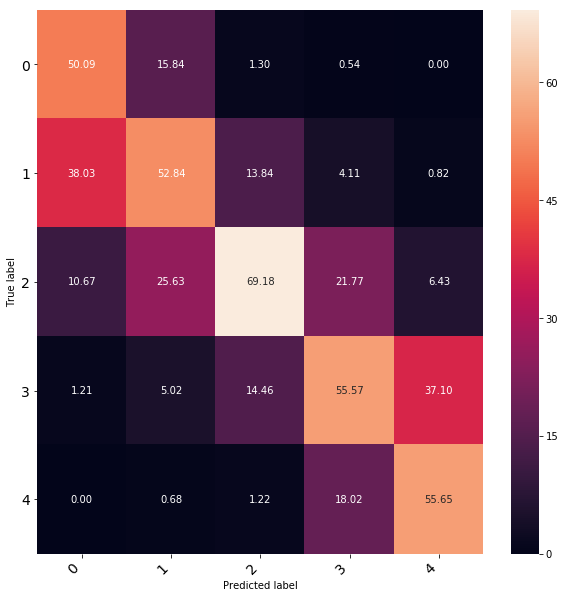

In [40]:
matriz_de_confusao = pd.DataFrame(metrics.confusion_matrix(y_true=y_test, y_pred=y_prediction_class)
                                 ,index=clf.classes_
                                 ,columns=clf.classes_)
plt.figure(figsize=(10,10))
plt.ylabel('Actual')
plt.xlabel('Predic')
heatmap = sns.heatmap(matriz_de_confusao.apply(lambda x: x/x.sum()*100), annot=True, fmt='.2f')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')


Utilizando o *Linear Suport Vector Classifier* **(LinearSVC)**, a acurácia total sobe (**63.46%** e score de **71.26%**) embora possamos ver que na matriz de confusão esse resultado é puxado mais pela classe 0 (neutral). Por ser um classificador linear, este algoritmo é fortemente afetado pela classe predominante

###  4. Multi-Layer Perceptron

In [41]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='relu', solver='adam')

%time clf.fit(X_train_dtm, y_train)

Wall time: 19min 56s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [44]:
y_prediction_class = clf.predict(X_test_dtm)
resultado = metrics.accuracy_score(y_pred=y_prediction_class, y_true=y_test) * 100
score = clf.score(X_train_dtm, y_train) * 100
print('Acurácia do algoritmo: %.2f%%' % resultado)
print('Score do algoritmo: %.2f%%' % score)

Acurácia do algoritmo: 63.60%
Score do algoritmo: 89.35%


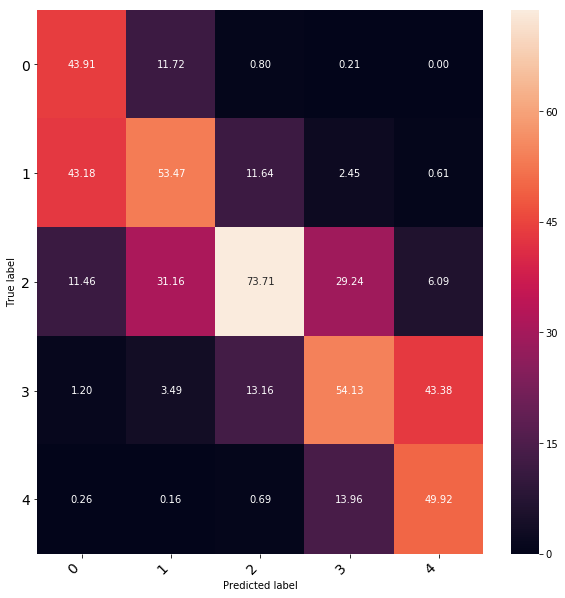

In [45]:
matriz_de_confusao = pd.DataFrame(metrics.confusion_matrix(y_true=y_test, y_pred=y_prediction_class)
                                 ,index=clf.classes_
                                 ,columns=clf.classes_)
plt.figure(figsize=(10,10))
plt.ylabel('Actual')
plt.xlabel('Predic')
heatmap = sns.heatmap(matriz_de_confusao.apply(lambda x: x/x.sum()*100), annot=True, fmt='.2f')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

Utilizando uma rede neural artificial do tipo Multi-Layer Perceptron gerou um score de **63.60%** e um score **89.35%**. Embora ela performe bem na previsão da classe 2 (Neutral) ela tem resultados pouco satisfatórios nas classes 0 (negative) e 4 (positive).

# 3. Deployment e geração do arquivo final

In [76]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [77]:
test_predict = test['Phrase']

test_predict_dtm = vectorizer.transform(test_predict)

final_predict = clf.predict(test_predict_dtm)


In [86]:
test['Sentiment'] = final_predict

In [91]:
test = test[['PhraseId','Sentiment']]
test.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3


In [92]:
test.to_csv('sentiment_analysis.csv', index=False)